## Data Collection & Labeling


### 1. Load and Inspect the Dataset

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Amazon-Deutsch-Dataset.csv")

In [2]:
# Check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3413 entries, 0 to 3412
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3413 non-null   int64  
 1   web-scraper-order      3413 non-null   object 
 2   web-scraper-start-url  3413 non-null   object 
 3   author                 3409 non-null   object 
 4   title                  3409 non-null   object 
 5   date                   3409 non-null   object 
 6   content                3409 non-null   object 
 7   rating                 3409 non-null   object 
 8   next                   3299 non-null   object 
 9   next-href              3303 non-null   object 
 10  Unnamed: 9             0 non-null      float64
dtypes: float64(1), int64(1), object(9)
memory usage: 293.4+ KB


In [3]:
# Describe numerical columns
df.describe()

,Unnamed: 0,Unnamed: 9
count,3413.000000,0.0
mean,1706.000000,NaN
std,985.392561,NaN
min,0.000000,NaN
25%,853.000000,NaN
50%,1706.000000,NaN
75%,2559.000000,NaN
max,3412.000000,NaN


In [4]:
# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 Unnamed: 0                  0
web-scraper-order           0
web-scraper-start-url       0
author                      4
title                       4
date                        4
content                     4
rating                      4
next                      114
next-href                 110
Unnamed: 9               3413
dtype: int64


In [5]:
# Preview first few rows
df.head(2)

,Unnamed: 0,web-scraper-order,web-scraper-start-url,author,title,date,content,rating,next,next-href,Unnamed: 9
0,0,1582056286-2631,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,MHS,Das Beste iPhone aller Zeiten,5. Januar 2020,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,"5,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN
1,1,1582056184-2351,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Amazon Customer,besser als beim hersteller,21. September 2019,"gestern bestellt, heute geliefert. besser geht...","5,0 von 5 Sternen",NaN,NaN,NaN


### 2. Clean Column Names and Extract Numeric Ratings

In [6]:
# Rename columns for clarity
df = df.rename(columns={
    'content': 'review_text',
    'rating': 'rating_raw'
})

# Extract numeric rating from German format (e.g., "4,0 von 5 Sternen")
df['rating'] = df['rating_raw'].str.extract(r'(\d+,\d+)')
df['rating'] = df['rating'].str.replace(',', '.').astype(float)

# Preview cleaned rating column
df[['rating_raw', 'rating']].head()


,rating_raw,rating
0,"5,0 von 5 Sternen",5.0
1,"5,0 von 5 Sternen",5.0
2,"4,0 von 5 Sternen",4.0
3,"5,0 von 5 Sternen",5.0
4,"5,0 von 5 Sternen",5.0


### 3. Compute Review Length

In [7]:
# Calculate number of words in each review
df['review_length'] = df['review_text'].astype(str).apply(lambda x: len(x.split()))

# Quick preview
df[['review_text', 'review_length']].head()

,review_text,review_length
0,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,28
1,"gestern bestellt, heute geliefert. besser geht...",13
2,"Ich mach es mal kurz:\nGut: Optik, Verarbeitun...",16
3,Amazon hat wieder super-schnell geliefert. Dan...,71
4,"Viel früher angekommen als angegeben, tolles H...",26


### 4. Apply Heuristic Labeling Rules

In [8]:
# Define rule-based labeling function
def label_review(row):
    if row['rating'] < 4.0:
        return 0  # genuine
    elif row['rating'] == 5.0 and row['review_length'] < 30:
        return 1  # possibly fake
    elif any(word in str(row['review_text']).lower() for word in ['beste', 'unglaublich', 'perfekt']):
        return 1  # possibly fake
    else:
        return 0  # default genuine

# Apply labeling
df['label'] = df.apply(label_review, axis=1)

# Show label distribution
df['label'].value_counts()


label
0    2716
1     697
Name: count, dtype: int64

### 5. Finalize Cleaned DataFrame

In [9]:
# Keep only relevant columns
df_final = df[['author', 'title', 'review_text', 'rating', 'review_length', 'label']]

# Preview final cleaned dataset
df_final.head()

,author,title,review_text,rating,review_length,label
0,MHS,Das Beste iPhone aller Zeiten,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,5.0,28,1
1,Amazon Customer,besser als beim hersteller,"gestern bestellt, heute geliefert. besser geht...",5.0,13,1
2,Joko Müller,Gutes Handy mit kleinen Schwächen,"Ich mach es mal kurz:\nGut: Optik, Verarbeitun...",4.0,16,0
3,Davorko,Ein sehr edles Stück dieses IPHONE 11,Amazon hat wieder super-schnell geliefert. Dan...,5.0,71,1
4,Chiara Natalia Sozzi,Super,"Viel früher angekommen als angegeben, tolles H...",5.0,26,1


## Text Preprocessing (German)

###  Preprocessing Code

In [10]:
import spacy
import re
from spacy.lang.de.stop_words import STOP_WORDS

# Load German language model
nlp = spacy.load("de_core_news_sm")

# Function for text cleaning and lemmatization
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-ZäöüßÄÖÜ ]', '', text)
    # Process using spaCy
    doc = nlp(text)
    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and token.is_alpha]
    return " ".join(tokens)

# Apply to a sample (to test speed first)
df_final['cleaned_text'] = df_final['review_text'].astype(str).apply(preprocess_text)

# Preview cleaned output
df_final[['review_text', 'cleaned_text']].head()


C:\Users\darsh\AppData\Local\Temp\ipykernel_17352\466136715.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['cleaned_text'] = df_final['review_text'].astype(str).apply(preprocess_text)


,review_text,cleaned_text
0,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,zufrieden Iphone Wechsel Iphone s riesig quant...
1,"gestern bestellt, heute geliefert. besser geht...",gestern bestellen liefern gehts rot sehen einf...
2,"Ich mach es mal kurz:\nGut: Optik, Verarbeitun...",mal kurzgut Optik Verarbeitung betriebssystem ...
3,Amazon hat wieder super-schnell geliefert. Dan...,Amazon superschnell liefern danken Iphone sowe...
4,"Viel früher angekommen als angegeben, tolles H...",früh ankommen angeben toll Handy xr Muss sagen...


## TF-IDF Vectorization (German)

### Import & Apply TF-IDF Vectorizer


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use top 5000 features to avoid sparsity
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Apply to cleaned text
X_tfidf = tfidf_vectorizer.fit_transform(df_final['cleaned_text'])

# Show shape and type
X_tfidf.shape

(3413, 5000)

### Prepare Feature Matrix and Labels

In [12]:
# Define features (X) and labels (y)
X = X_tfidf
y = df_final['label']

### Optional: See top features (for analysis or report appendix)

In [13]:
# View top 10 TF-IDF features
feature_names = tfidf_vectorizer.get_feature_names_out()
top_features = feature_names[:10]
print("Top features:", top_features)

Top features: ['aa' 'aaa' 'aan' 'abbekommen' 'abbilden' 'abbrechen' 'abbricht'
 'abdecken' 'abdeckung' 'abdunkel']


## Model Building

### Split Data for Training & Testing

In [14]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2730, 5000), (683, 5000), (2730,), (683,))

### Train Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and evaluate
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       544
           1       0.77      0.31      0.44       139

    accuracy                           0.84       683
   macro avg       0.81      0.64      0.67       683
weighted avg       0.83      0.84      0.81       683



### Add ROC-AUC Evaluation

ROC AUC Score: 0.8992


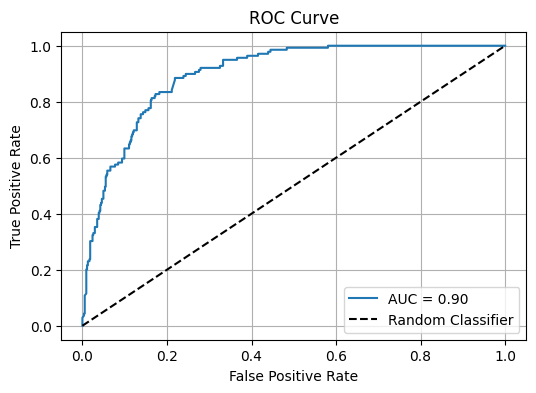

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities
y_proba = logreg.predict_proba(X_test)[:, 1]

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", round(roc_score, 4))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


### Train Random Forest Model (for comparison)

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       544
           1       0.68      0.54      0.60       139

    accuracy                           0.86       683
   macro avg       0.79      0.74      0.76       683
weighted avg       0.85      0.86      0.85       683



### SHAP Analysis on Random Forest

c:\Users\darsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


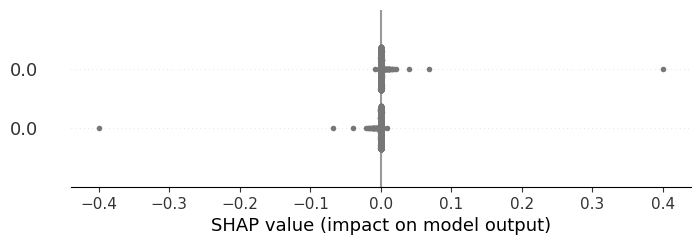

In [20]:
import shap

# Convert sparse TF-IDF test data to dense format
X_sample = X_test[:10].toarray()

# Initialize SHAP explainer for tree models
explainer = shap.Explainer(rf, X_sample)

# Calculate SHAP values for class 1 (fake)
shap_values = explainer(X_sample)

# Plot the feature importance
# shap.plots.beeswarm(shap_values)
shap.plots.beeswarm(shap_values[1])



c:\Users\darsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


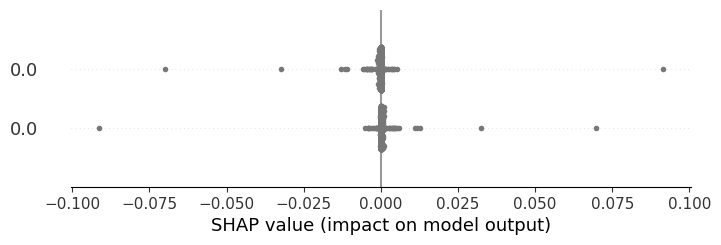

In [38]:
shap.plots.beeswarm(shap_values[0])

<class 'shap._explanation.Explanation'>
(100, 1000, 2)


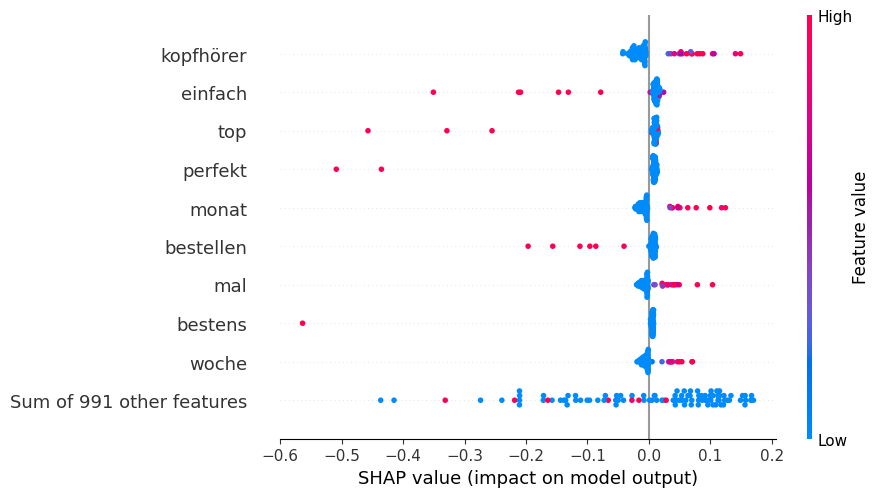

In [53]:
# 1. Define text and target
corpus = df_final['cleaned_text'].values
y = df_final['label'].values

# 2. Vectorize the cleaned text
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus)

# 3. Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the Random Forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5. Prepare for SHAP - convert to dense format with feature names
try:
    feature_names = vectorizer.get_feature_names_out()
except:
    feature_names = vectorizer.get_feature_names()

import pandas as pd
X_dense = pd.DataFrame(X_test.toarray(), columns=feature_names)
X_sample = X_dense.sample(100, random_state=42)

# 6. SHAP Explanation
import shap
explainer = shap.Explainer(rf, X_sample)
shap_values = explainer(X_sample)

# 7. Plot SHAP beeswarm chart
# shap.plots.beeswarm(shap_values[1])
print(type(shap_values))
print(shap_values.shape)
shap.plots.beeswarm(shap_values[..., 0])  # For class 0

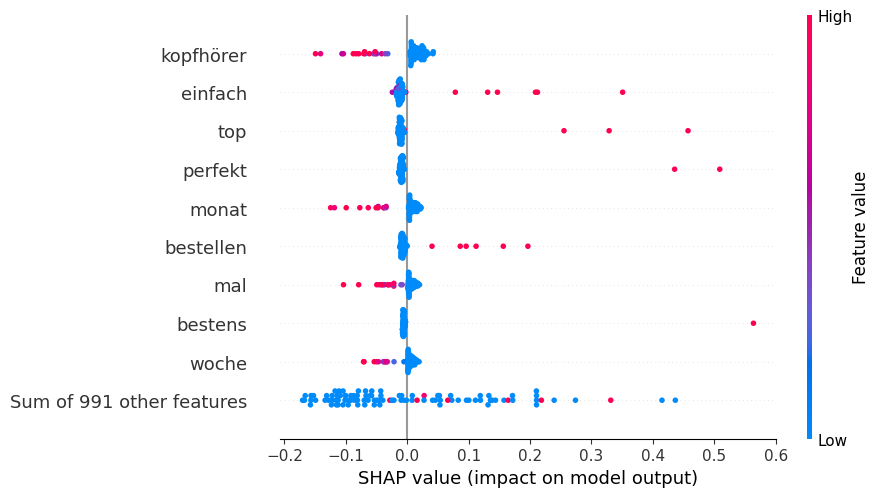

In [54]:
shap.plots.beeswarm(shap_values[..., 1])  # For class 1